In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import pingouin as pg
import os
import matplotlib.pyplot as plt
import matplotlib
import json
# import ptitprince as pt
font = {'family' : 'normal', 'weight': 'regular',
        'size'   : 25}

matplotlib.rc('font', **font)

/home/getz/PycharmProjects/CognitiveReflection/venv/lib/python3.8/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(
/home/getz/PycharmProjects/CognitiveReflection/venv/lib/python3.8/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.2, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


# Data cleaning

In [10]:

foldernames_002 = [
    './GPT3/greene/non_moral-07_07_2022__18:24:34',
    './GPT3/greene/impersonal_moral-07_07_2022__18:23:59',
    './GPT3/greene/personal_moral-07_07_2022__18:21:28'
]

A_B_foldernames = [
    './TRAININGS/non_moral_A_B-29_07_2022__12:14:42',
    './TRAININGS/impersonal_moral_A_B-29_07_2022__12:27:17',
    './TRAININGS/personal_moral_A_B-29_07_2022__12:16:23',
]

labels = ['non_moral', 'impersonal_moral', 'personal_moral']
dfs = []
dfs_with_unclear = []

for label, foldername in zip(labels,foldernames_002):

    df = pd.read_csv(open(foldername+'/results.csv', 'r'))
    df['exp'] = label
    # df['a'] = df['a'].str.lower()

    # exclude the "why?"
    df = df[df['q_id']==0]
    
    # parse 
    df['yes'] = df['a'].str.contains(pat=r'\b(yes)\b', regex=True, case=False) | df['a'].str.contains(pat=r'\b(\(A\))\b', regex=True, case=False)
    df['no'] =  df['a'].str.contains(pat=r'\b(no)\b', regex=True, case=False) | df['a'].str.contains(pat=r'\b(\(B\))\b', regex=True, case=False)

    df['unclear'] = df['yes'] == df['no']
    df['val'] = None
    df.loc[df['yes']==1, 'val'] = 'yes'
    df.loc[df['no']==1, 'val'] = 'no'
    df.loc[df['unclear']==1, 'val'] = 'unclear'
    dfs_with_unclear.append(df.copy())
    df = df[df['unclear']!=1] 
    dfs.append(df.copy())
    
df = pd.concat(dfs)
df_with_unclear = pd.concat(dfs_with_unclear)

def mean_by_exp_and_sub(df):
    # set cond label and merge 
    exp = df['exp'].unique()
    dfs = []
    for e in exp:
        d = df[df['exp']==e].groupby('iter').mean()
        d['exp'] = e
        dfs.append(d.copy())

    df2 = pd.concat(dfs)
    return df2

df2 = mean_by_exp_and_sub(df)
df2_with_unclear = mean_by_exp_and_sub(df_with_unclear)

# save unclear responses
df[df['val']=='unclear'].to_excel(foldername+'unclear.xlsx')



/tmp/ipykernel_61858/4211111872.py:27: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  df['yes'] = df['a'].str.contains(pat=r'\b(yes)\b', regex=True, case=False) | df['a'].str.contains(pat=r'\b(\(A\))\b', regex=True, case=False)
/tmp/ipykernel_61858/4211111872.py:28: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  df['no'] =  df['a'].str.contains(pat=r'\b(no)\b', regex=True, case=False) | df['a'].str.contains(pat=r'\b(\(B\))\b', regex=True, case=False)


In [12]:

print(df['a'].str.len().min())
df['a'].str.split(' ').str.len().mean()
# (df_with_unclear['unclear']==1).sum()/len(df_with_unclear)
# len()
# df_with_unclear

104


66.856

# Define functions

In [5]:
def raincloud(x, y, markersize, df):
    # adding color
    pal = "Set2"
    # f, ax = plt.subplots(figsize=(5*2.5, 5*2.5))

    ax = pt.half_violinplot(x=x, y=y, data=df, palette=pal, bw=.45, cut=0., linewidth=1,
                            scale="area", width=.8, inner=None, orient='v')

    ax = sns.stripplot(x=x, y=y, data=df, palette=pal, edgecolor="black", alpha=0.6, linewidth=1,
                       size=markersize, orient='v')


    ax2 = sns.pointplot(x=x, y=y, data=df, color='black',  join=False, ci=68, linewidth=1, edgecolor='black', capsize=.1)

    
def box_same_color(ax2):
    box_patches = [patch for patch in ax2.patches if type(
        patch) == matplotlib.patches.PathPatch]


    if len(box_patches) == 0:  # in matplotlib older than 3.5, the boxes are stored in ax2.artists
        box_patches = ax2.artists
    num_patches = len(box_patches)
    lines_per_boxplot = len(ax2.lines) // num_patches
    for i, patch in enumerate(box_patches):
        # Set the linecolor on the patch to the facecolor, and set the facecolor to None
        col = patch.get_facecolor()
        patch.set_edgecolor(col)
        patch.set_facecolor('None')

        # Each box has associated Line2D objects (to make the whiskers, fliers, etc.)
        # Loop over them here, and use the same color as above
        for line in ax2.lines[i * lines_per_boxplot: (i + 1) * lines_per_boxplot]:
            line.set_color(col)
            line.set_mfc(col)  # facecolor of fliers
            line.set_mec(col)  # edgecolor of fliers
# 

# Fig 1

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-5.717306,19,two-sided,0.000016,"[-0.21, -0.1]",2.10467,1405.101,1.0


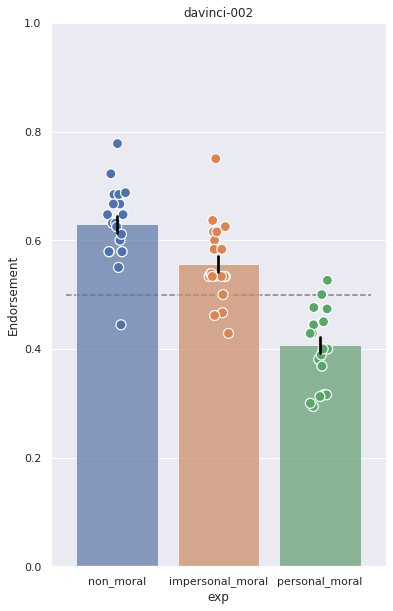

In [12]:
sns.set(rc={'figure.figsize':(6,10)})

# order = ['non_moral', 'impersonal_moral', 'personal_moral']
sns.barplot(x='exp', y='yes', data=df2, alpha=.7, errwidth=0, zorder=1)
sns.stripplot(x='exp', y='yes', data=df2, size=10, linewidth=1.2, zorder=2, edgecolor='white', jitter=True)
sns.pointplot(x='exp', y='yes', data=df2, color='black',  join=False, ci=68, edgecolor='white', capsize=0, zorder=3, scale=0)
# raincloud(x='exp', y='yes', markersize=9, df=df2)
x_lim = plt.gca().get_xlim()
plt.plot(x_lim, [.5, .5], ls='--', color='gray', zorder=0)
plt.ylim(0, 1)
plt.ylabel('Endorsement')
plt.title('davinci-002')

pg.ttest(df2[df2['exp']=='personal_moral']['yes'], df2[df2['exp']=='impersonal_moral']['yes'], paired=True)

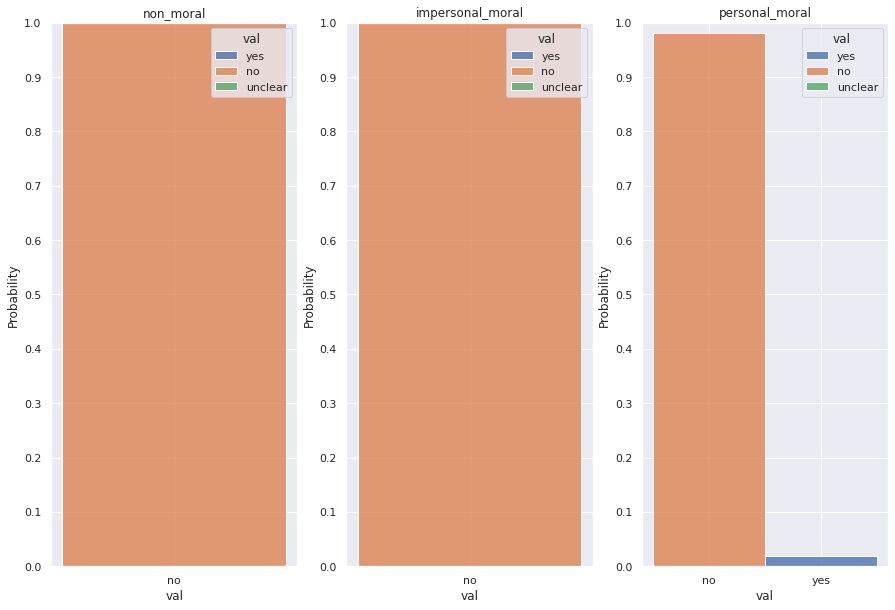

In [7]:
sns.set(rc={'figure.figsize':(15,10)})

exp = df['exp'].unique()
# df = df[df['unclear']!=1]
fig, axes = plt.subplots(nrows=1, ncols=len(exp))
# Draw a nested barplot by species and sex
for e, ax in zip(exp, axes.flat):
    sns.histplot(
        x='val', data=df[df['exp']==e], hue='val', hue_order=['yes', 'no', 'unclear'], stat='probability', alpha=.8, ax=ax)
    ax.set_ylim(0,1)
    ax.set_yticks(np.arange(0, 11)/10)
    ax.set_title(e)
# sns.displot(x='val', data=df, col='exp', hue='val', stat='probability', alpha=.8)
# sns.displot(x='val', data=df, col='exp', hue='val', stat='probability', alpha=.8)